In [27]:
# pip install sktime

Revursive Vs Direct Approach

In [28]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sklearn.exceptions import ConvergenceWarning
import requests
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNetCV
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)
from sktime.forecasting.compose import MultiplexForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.ets import AutoETS
from sktime.transformations.series.boxcox import LogTransformer


import warnings

In [29]:
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.forecasting.arima import AutoARIMA


def initialize_arima_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "deseasonalizer_daily",
                            Deseasonalizer(sp=24, model="additive"),
                        ),
                        ("residual_forecaster", AutoARIMA(suppress_warnings=True)),
                    ]
                ),

    return pipe


def initialize_elasticnet_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                ElasticNetCV(n_jobs=-1),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_rf_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=20),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_gb_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                GradientBoostingRegressor(n_estimators=200),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )
           
    return pipe


def initialize_hist_forecaster():
    deseasonalizer_daily = Deseasonalizer(sp=24, model="additive")
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                HistGradientBoostingRegressor(),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )
            
    return pipe


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


def initialize_cat_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                CatBoostRegressor(verbose=0, n_estimators=100),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_lgbm_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                LGBMRegressor(),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe


def initialize_xgb_forecaster():
    pipe = TransformedTargetForecaster(
                    [
                        (
                            "forecast",
                            make_reduction(
                                XGBRegressor(objective="reg:squarederror"),
                                window_length=24,
                                strategy="direct",
                            ),
                        ),
                    ]
                )

    return pipe

In [30]:
arima_pipeline = initialize_arima_forecaster()
elasticnet_pipeline = initialize_elasticnet_forecaster()
rf_pipeline = initialize_rf_forecaster()
gb_pipeline = initialize_gb_forecaster()
hist_pipeline = initialize_hist_forecaster()
cat_pipeline = initialize_cat_forecaster()
lgbm_pipeline = initialize_lgbm_forecaster()
xgb_pipeline = initialize_xgb_forecaster()


forecasting_models = {
    "arima_pipeline": arima_pipeline,
    "elasticnet_pipeline": elasticnet_pipeline,
    "rf_pipeline": rf_pipeline,
    "gb_pipeline": gb_pipeline,
    "hist_pipeline": hist_pipeline,
    "arima_pipeline": arima_pipeline,
    "cat_pipeline": cat_pipeline,
    "lgbm_pipeline": lgbm_pipeline,
    "xgb_pipeline": xgb_pipeline,
}

c:\Users\rkris\miniconda3\envs\slalomenv\Lib\site-packages\sktime\forecasting\compose\_reduce.py:1480: UserWarning: The `scitype` of the given `estimator` cannot be inferred. Assuming "tabular-regressor" = scikit-learn regressor interface. If this warning is followed by an unexpected exception, please consider report as a bug on the sktime issue tracker.
  warn(


In [31]:
selected_features = [
    "ail",
    "gas_price",
    "gas_reserve_margin",
    "wind_reserve_margin",
    "other_reserve_margin",
    "demand_supply_ratio",
    "rolling_mean",
    "rolling_std",
    "rolling_min",
    "rolling_max",
    "rolling_median",
    "exp_moving_avg",
]

In [32]:
price_old_df = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/supply_load_price.csv",
    parse_dates=["Date (MST)"],
    index_col="Date (MST)",
)

window = 24
price_old_df = price_old_df.sort_values(by="Date (MST)")
price_old_df = price_old_df.asfreq("H")

price_old_df['rolling_mean'] = price_old_df['price'].rolling(window).mean().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_std'] = price_old_df['price'].rolling(window).std().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_min'] = price_old_df['price'].rolling(window).min().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_max'] = price_old_df['price'].rolling(window).max().rolling(2).mean().shift(-window // 2)
price_old_df['rolling_median'] = price_old_df['price'].rolling(window).median().rolling(2).mean().shift(-window // 2)
price_old_df['exp_moving_avg'] = price_old_df['price'].ewm(span=24).mean()

In [33]:
price_old_df_filtered = price_old_df.loc["2023-01-01":"2023-03-28", selected_features + ["price"]]

y = price_old_df_filtered["price"]
X = price_old_df_filtered[selected_features]

# # scale ratios to percentages
X['gas_reserve_margin'] = X['gas_reserve_margin'] * 100
X['wind_reserve_margin'] = X['wind_reserve_margin'] * 100
X['other_reserve_margin'] = X['other_reserve_margin'] * 100
X['demand_supply_ratio'] = X['demand_supply_ratio'] * 100

C:\Users\rkris\AppData\Local\Temp\ipykernel_22192\505096190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gas_reserve_margin'] = X['gas_reserve_margin'] * 100
C:\Users\rkris\AppData\Local\Temp\ipykernel_22192\505096190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['wind_reserve_margin'] = X['wind_reserve_margin'] * 100
C:\Users\rkris\AppData\Local\Temp\ipykernel_22192\505096190.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [34]:
# standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [35]:
X.head(2)

,ail,gas_price,gas_reserve_margin,wind_reserve_margin,other_reserve_margin,demand_supply_ratio,rolling_mean,rolling_std,rolling_min,rolling_max,rolling_median,exp_moving_avg
Date (MST),,,,,,,,,,,,
2023-01-01 00:00:00,-1.073926,2.089899,-0.708704,0.431105,0.231709,-0.581608,-0.373124,-0.719275,1.131318,-0.737006,-0.196899,-0.406652
2023-01-01 01:00:00,-1.295700,2.089899,-0.845336,0.503513,0.412494,-0.778312,-0.382203,-0.715839,1.131318,-0.737006,-0.197942,-0.437197


In [36]:
cv = ExpandingWindowSplitter(
    initial_window=int(len(X) * 0.94), step_length=12, fh=np.arange(1, 13)
)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 10


In [37]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredScaledError, MeanSquaredError

# list_models = ["cat_pipeline", "lgbm_pipeline"]
# has she been started on the injection. How is she? Is the medication working. How long should she take this medication. Discharnge? What care should be given after she leaves

list_models = ['lgbm_pipeline']

rmse_cv_results = []
rmse_cv_std = []
for i in list_models:
    print(i)
    results = evaluate(
        forecaster=forecasting_models[i],
        y=y,
        X=X,
        cv=cv,
        strategy="refit",
        return_data=True,
        scoring=MeanSquaredError(square_root=True),
        backend="loky",
        error_score='raise'
    )
    
    rmse = results["test_MeanSquaredError"].mean()
    rmse_std = results["test_MeanSquaredError"].std()
    rmse_cv_results.append(rmse)
    rmse_cv_std.append(rmse_std)

lgbm_pipeline


In [38]:
rmse_cv_results_df = pd.DataFrame(
    {"Model": list_models, "RMSE_CV": rmse_cv_results, "RMSE_CV_STD": rmse_cv_std}
).sort_values(by=["RMSE_CV"])
rmse_cv_results_df

,Model,RMSE_CV,RMSE_CV_STD
0,lgbm_pipeline,96.54197,47.136732


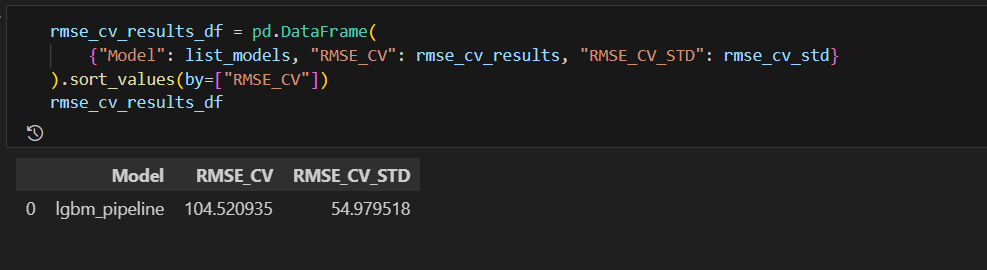

In [39]:
# forecasting_models[i].fit(y, X, fh=np.arange(1, 13))

In [40]:
# import pandas as pd

# def create_lagged_columns(X, lag_range=24):
#     lagged_names = []

#     for col in X:
#         for lag in range(1, lag_range + 1):
#             lagged_names.append(f"{col}_lag{lag}")

#     return lagged_names

# labels = create_lagged_columns(['price'] + X.columns.values.tolist(), lag_range=24)

In [41]:
# pd.DataFrame({'Coefficient': elasticnet_pipeline.forecaster_.estimators_[11].coef_, 'Label': labels}).sort_values(by=['Coefficient'], ascending=False).head(50)